# **`flygym`-MuJoCo exercise: CPG controller** 

<a target="_blank" href="https://colab.research.google.com/github/NeLy-EPFL/flygym/blob/main/notebooks/mujoco_CPG_control.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

**NOTE: You need to select a GPU instance on Google Colab for this notebook. Go to "Runtime" > "Change runtime type", select "GPU" under "Hardware accelerator" and click "Save."**

See [GitHub repo](https://github.com/NeLy-EPFL/flygym) for code and [documentation here](https://nely-epfl.github.io/flygym/).


In [54]:
import PIL.Image

import numpy as np
import pkg_resources
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
from flygym.envs.nmf_mujoco import NeuroMechFlyMuJoCo, MuJoCoParameters
from tqdm import trange
from flygym.util.config import all_leg_dofs
from flygym.state import stretched_pose

import cv2


from flygym.util.cpg_controller import (advancement_transfer, phase_oscillator, sine_output, initialize_solver,
                         phase_biases_tripod_measured, phase_biases_tripod_idealized,
                         phase_biases_ltetrapod_idealized, phase_biases_metachronal_idealized,
                         plot_phase_amp_output)

from flygym.arena.mujoco_arena import Tethered

In [55]:
# Initialize the simulation
run_time = 1
enable_adhesion = True

kp = 18.0
kp_tarsus1 = 45.0
stiffness = 0.0

sim_params = MuJoCoParameters(
    timestep=1e-4,
    render_mode="saved",
    render_playspeed=0.05,
    render_camera = "Animat/camera_left",
    enable_adhesion=enable_adhesion,
    draw_adhesion=enable_adhesion,
    adhesion_gain=20,
    draw_contacts=False,
    actuator_kp = kp,
    actuator_kp_tarsus1 = kp_tarsus1,
    joint_stiffness = stiffness,
)
nmf = NeuroMechFlyMuJoCo(
    sim_params=sim_params,
    init_pose=stretched_pose,
    actuated_joints=all_leg_dofs,
)

num_steps_base = int(run_time / nmf.timestep)

Front Tarsus1 actuator found actuator_position_joint_LFTarsus1
Front Tarsus1 actuator found actuator_position_joint_RFTarsus1


In [56]:
# Load recorded data
data_path = Path(pkg_resources.resource_filename('flygym', 'data'))
with open(data_path / 'behavior' / 'single_steps.pkl', 'rb') as f:
    data = pickle.load(f)

In [ ]:
np.mean(data[f"joint_{leg}Tarsus1"])

In [57]:
# Interpolate 5x
step_duration = len(data['joint_LFCoxa'])
interp_step_duration = int(step_duration * data['meta']['timestep'] / nmf.timestep)
data_block = np.zeros((len(nmf.actuated_joints), interp_step_duration))
measure_t = np.arange(step_duration) * data['meta']['timestep']
interp_t = np.arange(interp_step_duration) * nmf.timestep
for i, joint in enumerate(nmf.actuated_joints):
    data_block[i, :] = np.interp(interp_t, measure_t, data[joint])

In [58]:
change_angles = False
if change_angles:
    legs = ["LF", "RF"]
    for leg in legs:
        #nmf.physics.model.actuator(f"Animat/actuator_position_joint_{leg}Tarsus1").gainprm[0] = 45
        data_block[nmf.actuated_joints.index(f"joint_{leg}Tarsus1"), :] += np.deg2rad(30)


-0.5665207088743084

Text(0, 0.5, 'Angle (radian)')

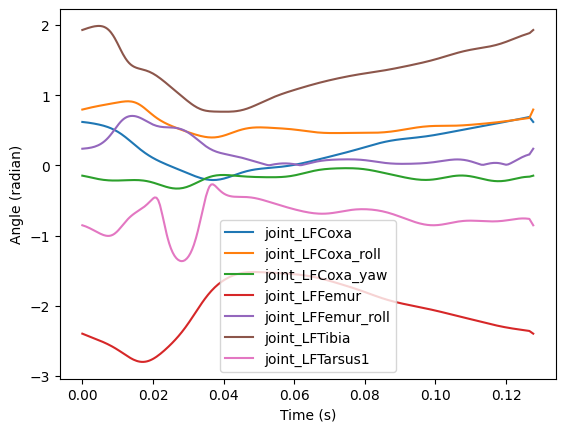

In [60]:
num_joints_to_visualize = 7
plt.plot(np.arange(data_block.shape[1]) * nmf.timestep,
         data_block[:num_joints_to_visualize].T,
         label=nmf.actuated_joints[:num_joints_to_visualize])
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Angle (radian)')

In [61]:
legs = ["RF", "RM", "RH", "LF", "LM", "LH"]
n_oscillators = len(legs)

t = np.arange(0, run_time, nmf.timestep)

n_joints = len(nmf.actuated_joints)
leg_ids = np.arange(len(legs)).astype(int)
joint_ids = np.arange(n_joints).astype(int)
# Map the id of the joint to the leg it belongs to (usefull to go through the steps for each legs)
match_leg_to_joints = np.array([i  for joint in nmf.actuated_joints for i, leg in enumerate(legs) if leg in joint])

In [62]:
# lets say we want 10 oscillations in the time period
n_steps = 12
frequencies = np.ones(n_oscillators) * n_steps / run_time

# For now each oscillator have the same amplitude
target_amplitudes = np.ones(n_oscillators) * 1.0
rates = np.ones(n_oscillators) * 20.0
phase_biases = phase_biases_tripod_idealized * 2 * np.pi
coupling_weights = (np.abs(phase_biases) > 0).astype(float) * 10.0 

# Simulation

In [63]:
n_stabilisation_steps = 2000
num_steps = n_stabilisation_steps + num_steps_base

# Initilize the simulation
np.random.seed(42)
start_ampl = np.ones(6)*0.2
obs, info = nmf.reset()
solver = initialize_solver(phase_oscillator, "dopri5", nmf.curr_time,
                            n_oscillators, frequencies,
                              coupling_weights, phase_biases,
                                start_ampl, rates,
                                int_params={"atol": 1e-6, "rtol": 1e-6, "max_step":100000})


# Initalize storage
obs_list = []
phases = np.zeros((num_steps, n_oscillators))
amplitudes = np.zeros((num_steps, n_oscillators))

joint_angles = np.zeros((num_steps, n_joints))
input_joint_angles = np.zeros(len(nmf.actuated_joints))

for i in trange(num_steps):

    res = solver.integrate(nmf.curr_time)
    phase = res[:n_oscillators]
    amp = res[n_oscillators:2*n_oscillators]

    phases[i, :] = phase
    amplitudes[i, :] = amp    

    if i == n_stabilisation_steps:
        # Now set the amplitude to their real values
        solver.set_f_params(n_oscillators, frequencies,
                              coupling_weights, phase_biases,
                                target_amplitudes, rates)
    if i > n_stabilisation_steps:
        indices = advancement_transfer(phase, interp_step_duration, match_leg_to_joints)
        # scale amplitude by interpolating between the resting values and i timestep value
        input_joint_angles = data_block[joint_ids, 0] + \
                  (data_block[joint_ids, indices]-data_block[joint_ids, 0])*amp[match_leg_to_joints]
    else:
        input_joint_angles = data_block[joint_ids, 0]

    joint_angles[i, :] = input_joint_angles
    if enable_adhesion:
        adhesion_signal = nmf.get_adhesion_vector()
    else:
        adhesion_signal = np.zeros(6)

    action = {"joints": input_joint_angles, "adhesion": adhesion_signal}
    
    obs, reward, terminated, truncated, info = nmf.step(action)
    obs_list.append(obs)
    render_status = nmf.render()

 56%|█████▌    | 6696/12000 [00:22<00:17, 294.92it/s]


KeyboardInterrupt: 

In [ ]:

video_path = Path(f"Tarsus/changeang{change_angles}_Ftars1kp{kp_tarsus1}_jointstiffness{stiffness}.mp4")
nmf.save_video(video_path, n_stabilisation_steps*nmf.timestep)

from ipywidgets import Video
Video.from_file(video_path)

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free...')

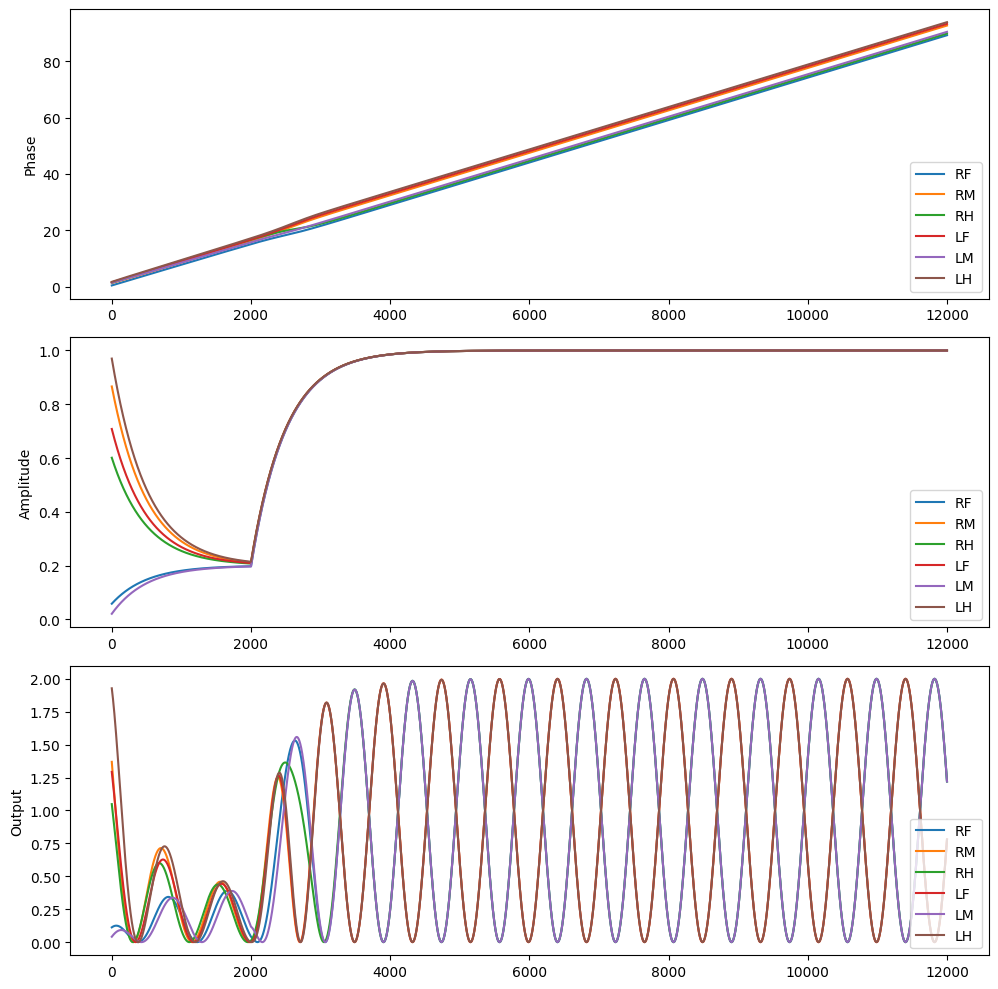

In [ ]:
plot_phase_amp_output(phases+np.arange(6)*0.3, amplitudes, sine_output(phases, amplitudes), legs)

# Gait diagram

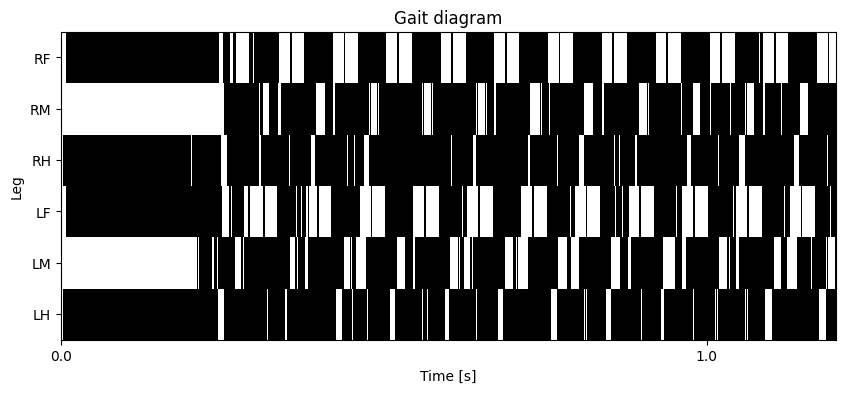

In [ ]:
# plot the gait diagram

# Map the id of the force sensors to the leg it belongs to
leg_force_sensors_ids = {leg:[] for leg in legs}
for i, collision_geom in enumerate(nmf.contact_sensor_placements):
    for leg in legs:
        if leg in collision_geom:
            leg_force_sensors_ids[leg].append(i)   

t_ids = np.arange(0, num_steps, 1)
time = t_ids*nmf.timestep

# Build an where lines are legs, columns are timepoint and there is a one in the array if the left leg is in contact with the ground
# and a zero if it is not
all_legs_contact = np.zeros((len(legs), num_steps))
gait_diagram_leg_order = ["RF", "RM", "RH", "LF", "LM", "LH"]

assert set(gait_diagram_leg_order) == set(legs)

for t in range(num_steps):
    for l, leg in enumerate(gait_diagram_leg_order):
        all_legs_contact[l, t] = np.sum(obs_list[t]["contact_forces"][2][leg_force_sensors_ids[leg]]) > 0

# plot the gait diagram leg vs time; Should appear black if the leg is in contact with the ground
# median filter the contat to smooth the gait diagram

from scipy.signal import medfilt

plt.figure(figsize=(10, 4))
#all_legs_contact_smooth = medfilt(all_legs_contact, kernel_size=(1, 3))
plt.imshow((np.logical_not(all_legs_contact)), cmap="gray", aspect="auto", interpolation="none")
plt.xlabel("Time [s]")
plt.ylabel("Leg")
plt.yticks(np.arange(len(legs)), gait_diagram_leg_order)
plt.xticks(t_ids[::10000], time[::10000])
plt.title("Gait diagram")
plt.show()